In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import popoff
from average_traces import AverageTraces, SingleCells
from Session import Session, SessionLite
import numpy as np
import os
import matplotlib.pyplot as plt
import math
from matplotlib import gridspec
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats

/home/jrowland/Documents/code/pop-off/popoff/popoff/loadpaths.py


In [2]:
# global plotting params
plt.style.use('ggplot')
# gg plot colors are nice but want seaborn style
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

sns.set()
sns.set_style('white')
params = {'legend.fontsize': 'xx-large',
          'text.usetex':False,
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)

figure_path = '/home/jrowland/mnt/qnap/Figures/bois'

In [3]:
params = {'legend.fontsize': 'xx-large',
          'text.usetex':False,
         'axes.labelsize': 'medium',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

In [4]:
dff = AverageTraces('dff')
dff.build_trace_dict()

In [18]:
# spks = AverageTraces('spks')
# spks.build_trace_dict()

In [19]:
# denoised = AverageTraces('denoised_flu')
# denoised.build_trace_dict()

AttributeError: 'SingleCells' object has no attribute 'trace_dict'

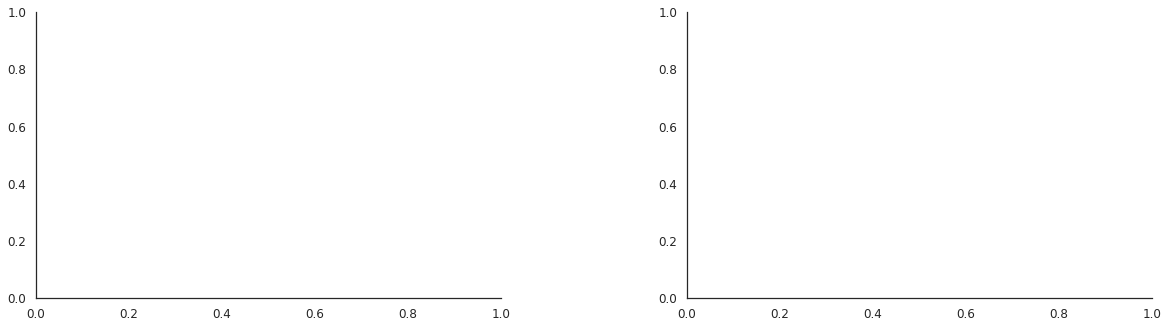

In [221]:
plt.figure(figsize=(20, 20))
outer = gridspec.GridSpec(3,1, hspace=0.4, wspace=0.8)

dff.s1s2_plot((-0.02, 0.06), outer[0], stim_type='test', balance=False)
# denoised.s1s2_plot((-0.02, 0.06), outer[1], stim_type='test', balance=False)
# spks.s1s2_plot((-0.005, 0.005), outer[2], stim_type='test', balance=False)

In [133]:
dff.sessions

{0: instance Mouse RL070, run 28 of Session class,
 1: instance Mouse RL070, run 29 of Session class,
 2: instance Mouse J048, run 27 of Session class,
 3: instance Mouse J048, run 28 of Session class,
 4: instance Mouse J048, run 29 of Session class,
 5: instance Mouse J048, run 30 of Session class,
 6: instance Mouse J048, run 32 of Session class,
 7: instance Mouse J064, run 10 of Session class,
 8: instance Mouse J064, run 11 of Session class,
 9: instance Mouse J064, run 14 of Session class,
 11: instance Mouse J063, run 9 of Session class,
 12: instance Mouse RL048, run 23 of Session class,
 13: instance Mouse RL048, run 24 of Session class,
 14: instance Mouse RL048, run 25 of Session class,
 15: instance Mouse RL048, run 28 of Session class,
 16: instance Mouse RL048, run 29 of Session class,
 18: instance Mouse J065, run 11 of Session class}

In [24]:
dff = SingleCells('dff')
s1s2_dict = dff.s1s2_dict

/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:5216: RuntimeWarning: Mean of empty slice.
  dtype=dtype, **kwargs)[()]
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


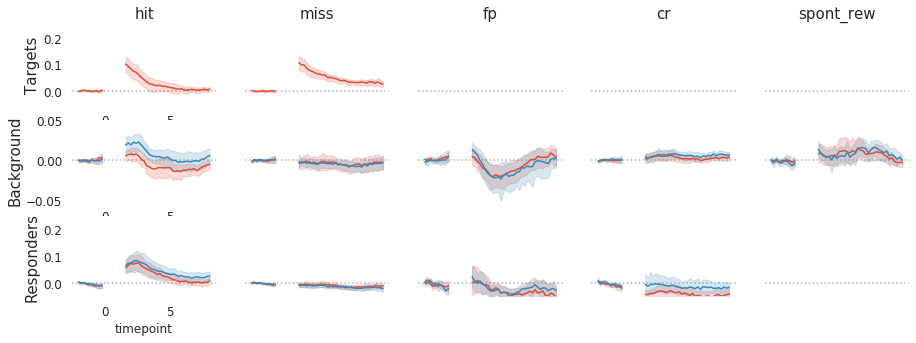

In [25]:
plt.figure(figsize=(15,5))


n_plots = 0
for cell_type in ['Targets', 'Background', 'Responders']:
    
    if cell_type == 'Target':
        ylim = (0,0.)
    elif cell_type == 'Background':
        ylim = (-0.05, 0.05)
    else:
        ylim = (-0.05, 0.25)
        
    for trial_type in ['hit', 'miss', 'fp', 'cr', 'spont_rew']:
        
        n_plots += 1 
        plt.subplot(3, 5, n_plots)
        plt.ylim(ylim)
        
        sns.despine(left=True, bottom=True)
        
        if cell_type == 'Targets':
            plt.gca().set_title(trial_type, fontsize=15)
            
        
        plt.axhline(y=0, linestyle=':', color='gray', alpha=0.6)
        for idx, region in enumerate(['s1', 's2']):
            
            trace = s1s2_dict[region][cell_type][trial_type]
            
            if n_plots==5:
                label = region
            else:
                label = None
                
            ax = sns.lineplot(data=trace[trace['timepoint']<0], x='timepoint', y='dff', label=label,
                              color=colors[idx])
            
            # 1.5 If youre plotting easy trials
            ax2 = sns.lineplot(data=trace[trace['timepoint']>=1.5], x='timepoint', y='dff', label=None,
                              color=colors[idx])
            
        if trial_type == 'hit':
            ylabel=cell_type
        else:
            ylabel=None
            ax.set(xlabel=None, xticklabels=[], yticklabels=[])
            
        ax.set_ylabel(ylabel, fontsize=15)
            
            
plt.savefig(os.path.join(figure_path, 'averageTracesEasy.pdf'),bbox_inches="tight")
plt.savefig(os.path.join(figure_path, 'averageTracesEasy.png'),bbox_inches="tight")
#sns.lineplot(data=trace_dict['Background']['miss'], x='timepoint', y='dff')

In [381]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    
    
    doesnt work with 2d yet
    """
    average = np.average(values, weights=weights, axis=1)
    # Wrong
    variance = np.array([np.average((value-average)**2, weights=weights) for value in values])
    
    
    return (average, math.sqrt(variance))

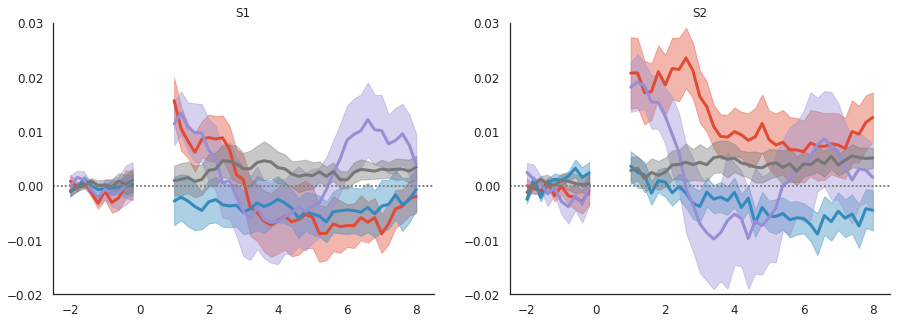

In [64]:
plt.figure(figsize=(15,5))
outcomes = ['hit', 'miss', 'fp', 'cr']

for idx, region in enumerate(['s1', 's2']):
    
    ax = plt.subplot(1,2,idx+1)
    
    color_idx = 0
    
    for outcome in outcomes:
        
        trace = s1s2_dict[region]['Background'][outcome]

        if outcome in ['hit', 'miss']:
            weight = np.array([sum(np.logical_and(session.photostim==1, session.outcome==outcome)) 
                               for session in dff.sessions.values()])
            
        else:
            weight = np.array([sum(session.outcome==outcome) for session in dff.sessions.values()])
            
            
        no_weighting = False
                
        if no_weighting:
            weight = np.ones(len(weight))

        t_len = len(dff.times_use)
        reshaped = trace['dff'].to_numpy().reshape((t_len, int(len(trace['dff'])/t_len)), order='F')
        
        # You need to look into why this has NaNs
        nonnan_idxs = np.where(~np.isnan(np.mean(reshaped, axis=0)))[0]

        weighted_avg = np.average(reshaped[:, nonnan_idxs], weights=weight[nonnan_idxs], axis=1)
        
        
        # Not yet weighted
        ci = np.nanstd(reshaped, axis=1) / math.sqrt(reshaped.shape[1])

        times = dff.times_use

        for ii, t_idx in enumerate([times<0, times>=1]):  # Two plots to make the gap
            
            if ii ==0:
                label = outcome
            else:
                label = None
            
            plt.plot(times[t_idx], weighted_avg[t_idx], color=colors[color_idx], linewidth=3, label=label)
            plt.fill_between(times[t_idx], weighted_avg[t_idx]-ci[t_idx], 
                             weighted_avg[t_idx] + ci[t_idx], alpha=0.4, color=colors[color_idx])

        plt.axhline(y=0, linestyle=':', color='gray', alpha=0.8)
        
        color_idx += 1

        # Fills whole vector with same number for some reason
        #ci = sns.utils.ci(sns.algorithms.bootstrap(reshaped, axis=1), axis=0)[0,:]

        plt.ylim((-0.02, 0.03))

        plt.title(region.upper())

#         plt.legend()
        
        # WHY ARE THERE FUCKING NANS IN THIS PLOT
        
plt.savefig(os.path.join(figure_path, 'wooooooo.pdf'),bbox_inches="tight")


In [93]:
outcome = 'hit'
ps_type = 2

running_n = 0
n = 0
rob_mean = []
for session in dff.sessions.values():
    
    n_trial_in_session = sum(np.logical_and(session.photostim==ps_type, session.outcome==outcome))
    rob_mean.append(np.mean(reshaped[:, running_n:n_trial_in_session+running_n], 1))
    
    running_n += n_trial_in_session
    
rob_mean = np.array(rob_mean)

In [69]:
def get_range(session, plot=False):

    if session.mouse == 'RL048' or session.mouse == 'J048':
        # Need to be same length to do wilcoxon
        # Rob does 500ms  so 3 ish frames
        n_frames = 3
        pre_range = [16-n_frames, 16]
        post_range = [30, 30+n_frames]
    else:
        # 3 frames above so 15 frames here
        n_frames = 15
        pre_range = [100-n_frames, 100]
        post_range = [160, 160+n_frames]

    if plot:
        plt.figure()
        plt.plot(np.mean(session.behaviour_trials, (0,1)))

        for pre, post in zip(post_range, pre_range):
            plt.axvline(pre, color='blue')
            plt.axvline(post, color='red')
    
    return pre_range, post_range

In [70]:
sessions = dff.sessions
session = sessions[2]

In [81]:
def get_injected_propagated(session, region='s1', n_cells='all', outcome='hit'):

    behaviour_trials = session.behaviour_trials
    
    
    if outcome in ['hit', 'miss']:
        trial_mask = np.logical_and(session.outcome==outcome, session.photostim==1)
    else:
        raise NotYetImplementError('As no targets')

    pre_range, post_range = get_range(session)

    targets = np.ma.array(behaviour_trials, mask=~session.is_target, copy=True)
    background = np.ma.array(behaviour_trials, mask=session.is_target, copy=True)

    injected = targets[:, :, post_range].mean(2) - targets[:, :, pre_range].mean(2)
    propagated = background[:, :, post_range].mean(2) - background[:, :, pre_range].mean(2) 

    if n_cells == 'all':
        injected = injected[:, np.logical_not(session.photostim==0)]
        propagated = propagated[:, np.logical_not(session.photostim==0)]
    else:
        injected = injected[:, np.logical_and(session.trial_subsets==n_cells, session.outcome==outcome)]
        propagated = propagated[:, np.logical_and(session.trial_subsets==n_cells, session.outcome==outcome)]
    
    if region == 's1':
        cell_bool = session.s1_bool
    elif region == 's2':
        cell_bool = session.s2_bool
    else:
        cell_bool = np.repeat(True, len(session.s1_bool))
        
    propagated = propagated[cell_bool, :]

    # Cell sum
    injected = injected.sum(0)
    propagated = propagated.sum(0)

    return injected, propagated

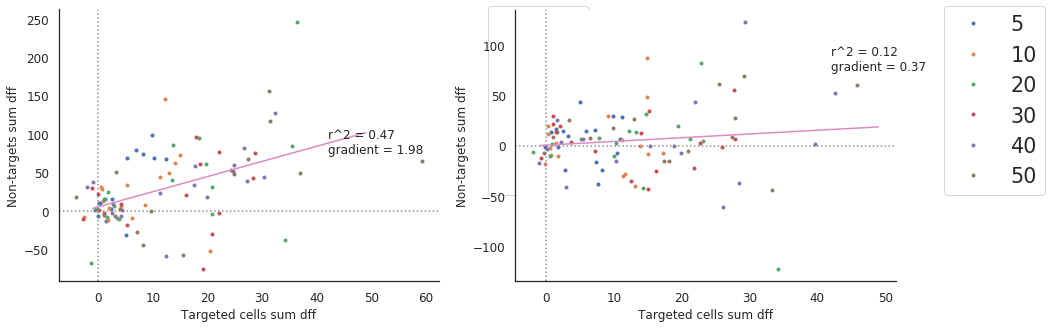

In [84]:
plot_all_trials = False


plt.figure(figsize=(15,5))
for idx, outcome in enumerate(['hit', 'miss']):
    
    plt.subplot(1,2,idx+1)

    #for region in ['s1', 's2']:
    regress_x = []
    regress_y = []

    for n_cells in [5,10,20,30,40,50]:

        injected_all = []
        propagated_all = []

        for session in sessions.values():
            if session.behaviour_trials.shape[0] < 200:
                continue
            else:
                injected, propagated = get_injected_propagated(session, region='both', 
                                                               n_cells=n_cells, outcome=outcome)
                injected_all.append(injected)
                propagated_all.append(propagated)

        if plot_all_trials:
            injected_all = np.concatenate(injected_all)
            propagated_all = np.concatenate(propagated_all)
        else:
            injected_all = [np.mean(inj) for inj in injected_all]
            propagated_all = [np.mean(prop) for prop in propagated_all]

        plt.plot(injected_all, propagated_all, '.', label=n_cells)
        regress_x.append(injected_all)
        regress_y.append(propagated_all)

    plt.axvline(0, color='gray', linestyle=':', alpha=0.9)
    plt.axhline(0, color='gray', linestyle=':', alpha=0.9)

    regress_x = np.array(regress_x)
    regress_x = regress_x[~np.isnan(regress_x)]

    regress_y = np.array(regress_y)
    regress_y = regress_y[~np.isnan(regress_y)]

    slope, intercept, r_value, p_value, std_err = stats.linregress(regress_x, regress_y)
    x = np.arange(-1, 50)
    plt.plot(x, intercept + slope * x, '-')

    plt.xlabel('Targeted cells sum dff')
    plt.ylabel('Non-targets sum dff')
    plt.text(42, 75, f'r^2 = {round(r_value, 2)}\ngradient = {round(slope, 2)}', fontsize=12)

    plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig(os.path.join(figure_path, 'gradientBoi.pdf'),bbox_inches="tight")

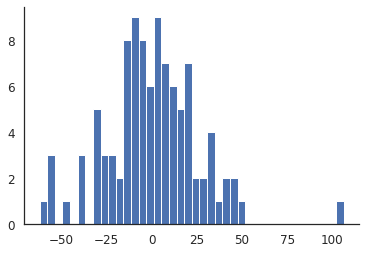

In [217]:
prediction = intercept + slope * regress_x
residual = (regress_y - prediction)
h = plt.hist(residual, 40)